# Advanced representation of saliency maps

## Bibliotheque

In [1]:
import os
import shutil
import numpy as np
from PIL import Image
from typing import Union, Optional

import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap, Colormap

from scipy.ndimage import gaussian_filter

## Saliency

In [2]:
class RGBImage:
    def __init__(self, path: str = None, image: Image.Image = None):
        if path:
            self.image = Image.open(path).convert('RGB')
        elif image:
            self.image = image
        else:
            raise ValueError("Either path or image must be provided")
        
        self.data = np.array(self.image) / 255.0

    @classmethod
    def from_array(cls, array: np.ndarray) -> 'RGBImage':
        image = Image.fromarray((array * 255).astype(np.uint8), mode='RGB')
        return cls(image=image)

class Saliency:
    def __init__(self, path: str, signed: bool = False):
        rgb_image = RGBImage(path)
        self.data = rgb_image.data
        
        
        if signed:
            self.data = (self.data * 2) - 1
        else:
            self.data = self.data
            
saliency = Saliency('test_saliency_img.png', signed=False)
image = RGBImage('test.jpg')
cmap= plt.cm.gist_heat
Cmap = Colormap

## represent_heatmap

In [3]:
def represent_heatmap(saliency: Saliency, cmap: Union[None, Cmap] = None) -> RGBImage:
    saliency_data = np.mean(saliency.data, axis=2)  # Convert to grayscale

    # Apply the colormap to the saliency data (2D grayscale)
    colored_data = cmap(saliency_data)
    
    # Convert to RGB format (ignoring the alpha channel if it exists)
    rgb_data = (colored_data[:, :, :3] * 255).astype(np.uint8)
    heatmap_image = Image.fromarray(rgb_data, mode='RGB')
    
    return RGBImage(image=heatmap_image)


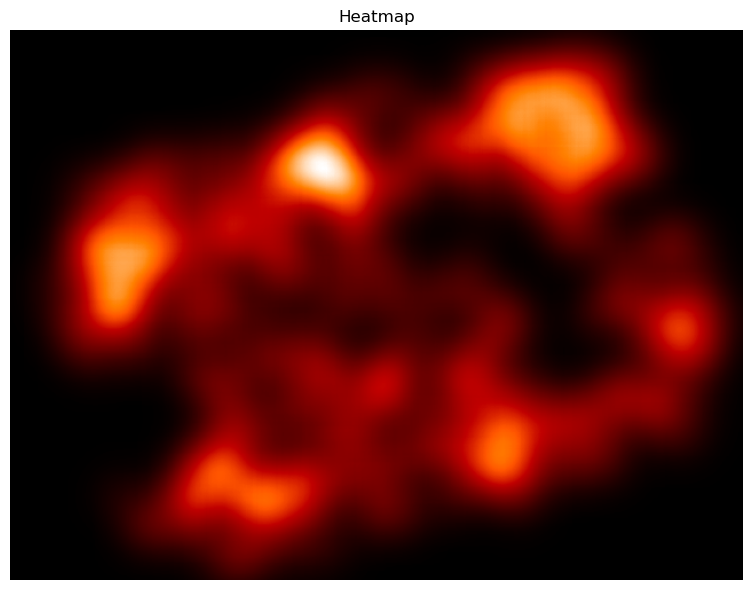

In [4]:
heatmap = represent_heatmap(saliency, cmap=cmap)

# Plotting the results
fig, axes = plt.subplots(1, 1, figsize=(12, 6))

# Show heatmap
axes.imshow(heatmap.image)
axes.set_title("Heatmap")
axes.axis("off")

plt.tight_layout()
plt.show()

## represent_heatmap_overlaid

In [5]:
def represent_heatmap_overlaid(saliency: Saliency, image: RGBImage, cmap: Union[None, Cmap]) -> RGBImage:
    alpha = 0.6
    heatmap_image = represent_heatmap(saliency, cmap)
    
    heatmap_array = np.array(heatmap_image.image)  
    image_array = np.array(image.image)
    
    overlaid_array = np.clip((alpha * heatmap_array + (1 - alpha) * image_array), 0, 255).astype(np.uint8)
    
    overlaid_image = Image.fromarray(overlaid_array, mode='RGB')
    
    return RGBImage(image=overlaid_image)


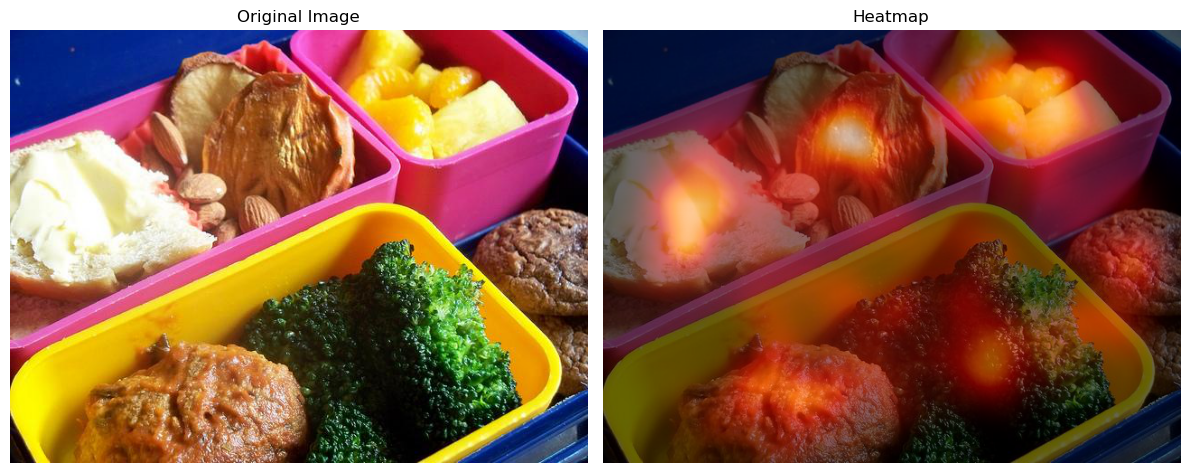

In [6]:

heatmap = represent_heatmap_overlaid(saliency, image, cmap)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Show original image
axes[0].imshow(image.image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Show heatmap
axes[1].imshow(heatmap.image)
axes[1].set_title("Heatmap")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## represent_isolines

In [7]:
def represent_isolines(saliency: Saliency, cmap: Union[None, Cmap]) -> RGBImage:
    
    saliency_data = np.mean(saliency.data, axis=2)
    fig, ax = plt.subplots(figsize=(saliency_data.shape[1] / 100, saliency_data.shape[0] / 100))
    fig.patch.set_facecolor('black')
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    # Draw contours based on the saliency data
    contours = ax.contour(saliency_data, levels=11, cmap=cmap)
    
    ax.axis('off')
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    
    image_array = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8').reshape(height, width, 4)[:, :, :3] 
    image_array = np.flip(image_array, axis=0)
    
    plt.close(fig)
    
    # Convert to PIL Image and wrap it in RGBImage
    isoline_image = Image.fromarray(image_array, mode='RGB')
    
    return RGBImage(image=isoline_image)

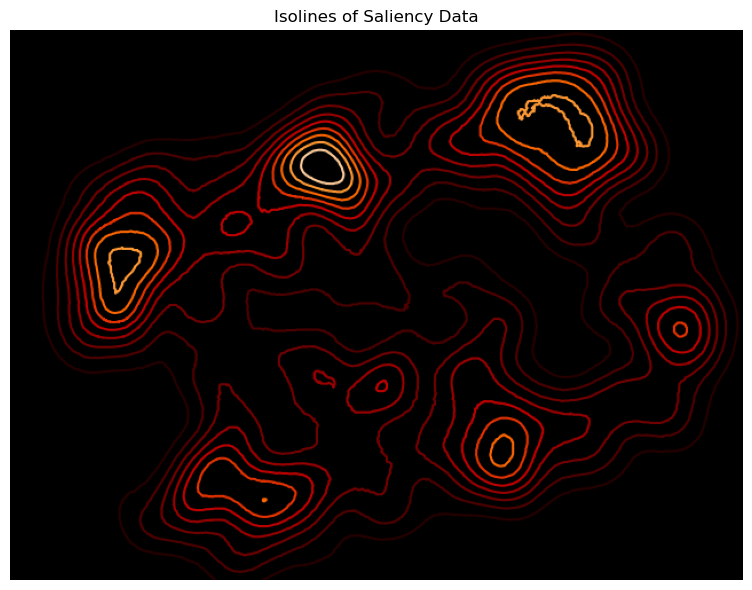

In [8]:
isolines = represent_isolines(saliency, cmap)

fig, axes = plt.subplots(1, 1, figsize=(12, 6))

axes.imshow(isolines.image)
axes.set_title("Isolines of Saliency Data")
axes.axis("off")

plt.tight_layout()
plt.show()

## represent_isolines_superimposed

In [9]:
def represent_isolines_superimposed(saliency: Saliency, image: RGBImage, cmap: Union[None, Cmap]) -> RGBImage:
    alpha = 0.7
    
    isolines_image = represent_isolines(saliency, cmap)
    isolines_array = np.array(isolines_image.image)
    image_array = np.array(image.image)
    
    superimposed_array = np.clip((alpha * isolines_array + (1 - alpha) * image_array), 0, 255).astype(np.uint8)
    
    superimposed_image = Image.fromarray(superimposed_array, mode='RGB')
    
    return RGBImage(image=superimposed_image)


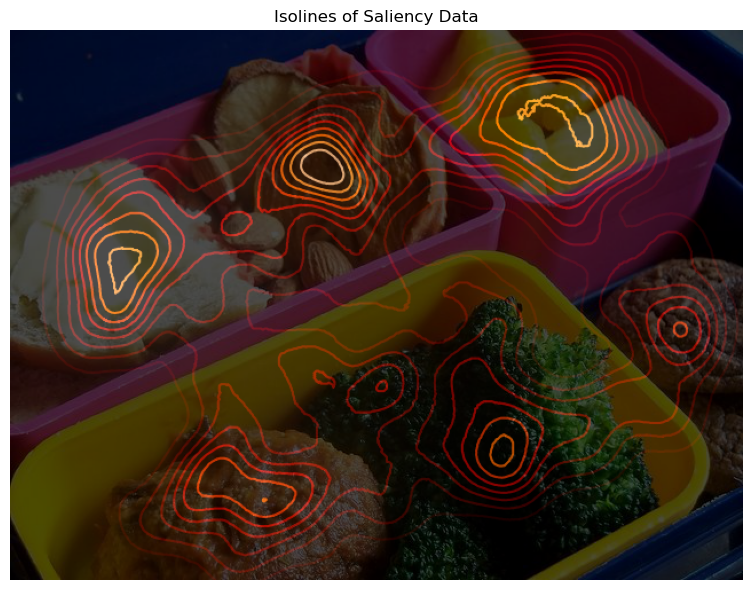

In [10]:
isolines = represent_isolines_superimposed(saliency,image, cmap)

fig, axes = plt.subplots(1, 1, figsize=(12, 6))

axes.imshow(isolines.image)
axes.set_title("Isolines of Saliency Data")
axes.axis("off")

plt.tight_layout()
plt.show()

## represent_hard_selection

In [11]:
def represent_hard_selection(saliency: Saliency, image: RGBImage, threshold: float) -> RGBImage:
    saliency_data = np.mean(saliency.data, axis=2)
    image_array = np.array(image.image)

    mask = saliency_data >= threshold

    selected_image_array = np.zeros_like(image_array)  
    selected_image_array[mask] = image_array[mask]

    selected_image = Image.fromarray(selected_image_array.astype(np.uint8), mode='RGB')
    
    return RGBImage(image=selected_image)


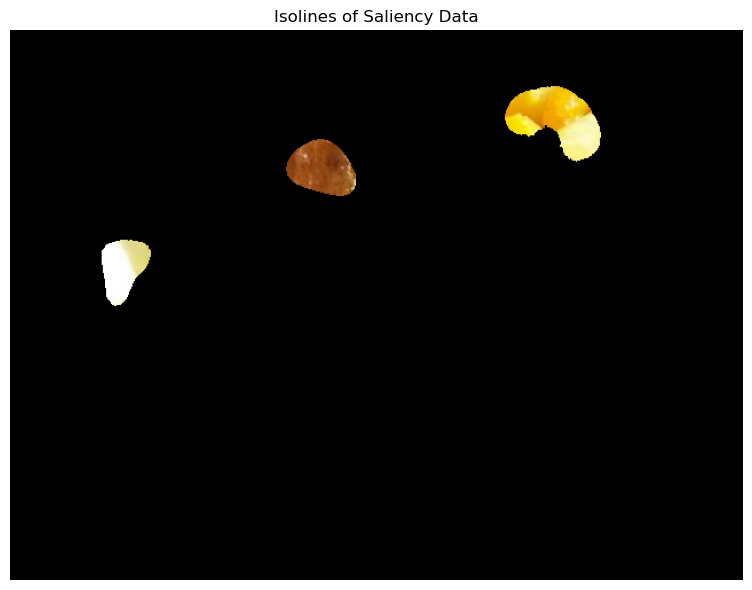

In [12]:
hard = represent_hard_selection(saliency, image, 0.75)

fig, axes = plt.subplots(1, 1, figsize=(12, 6))

axes.imshow(hard.image)
axes.set_title("Isolines of Saliency Data")
axes.axis("off")

plt.tight_layout()
plt.show()

## represent_soft_selection

In [13]:
def represent_soft_selection(saliency: Saliency, image: RGBImage, threshold: float) -> RGBImage:
    # Convertir les données de saliency et d'image en tableaux NumPy
    saliency_data = np.array(saliency.data)
    image_array = np.array(image.image)
    
    
    soft_selection_array = image_array * saliency_data 

    soft_selection_image = Image.fromarray(soft_selection_array.astype(np.uint8), mode='RGB')

    return RGBImage(image=soft_selection_image)


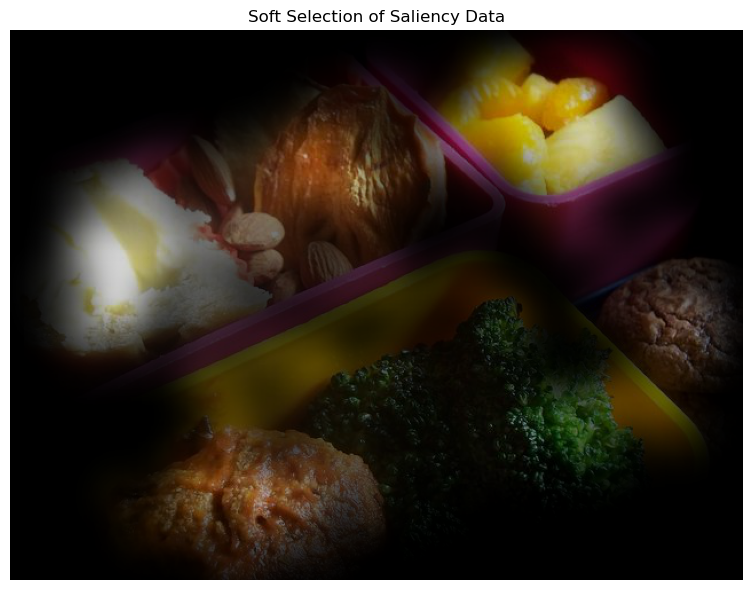

In [14]:
soft = represent_soft_selection(saliency, image, 0)

fig, axes = plt.subplots(1, 1, figsize=(12, 6))

axes.imshow(soft.image)
axes.set_title("Soft Selection of Saliency Data")
axes.axis("off")

plt.tight_layout()
plt.show()

## Comparaison 

In [15]:
def plot_comparison(results, titles, max_cols=4):
    total_images = len(results)
    rows = (total_images + max_cols - 1) // max_cols
    
    fig, axes = plt.subplots(rows, max_cols, figsize=(15, 5 * rows))
    axes = axes.flatten()
    
    for i in range(total_images):
        axes[i].imshow(results[i].image)
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    for j in range(total_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [16]:
def grid_comparison(images_path, saliency_path, threshold=0.75, cmap=plt.cm.gist_heat):
    saliency = Saliency(saliency_path, signed=False)
    image = RGBImage(images_path)

    titles = ["Image Original", "Heatmap", "Heatmap Overlaid", "Isoline", "Isoline Overlaid", "Hard Selection", "Soft Selection"]

    # Apply different methods
    list_img = []
    list_img.append(image)
    list_img.append(represent_heatmap(saliency, cmap=cmap))
    list_img.append(represent_heatmap_overlaid(saliency, image, cmap=cmap))
    list_img.append(represent_isolines(saliency, cmap=cmap))
    list_img.append( represent_isolines_superimposed(saliency, image, cmap=cmap) )
    list_img.append(represent_hard_selection(saliency, image, threshold))
    #for i in np.arange(0.4, 0.9, 0.1):
    #    list_img.append(represent_hard_selection(saliency, image, i))
    #    titles.append(titles[5] + str(round(i, 2)))

    list_img.append(represent_soft_selection(saliency, image, threshold))

    plot_comparison(list_img, titles)



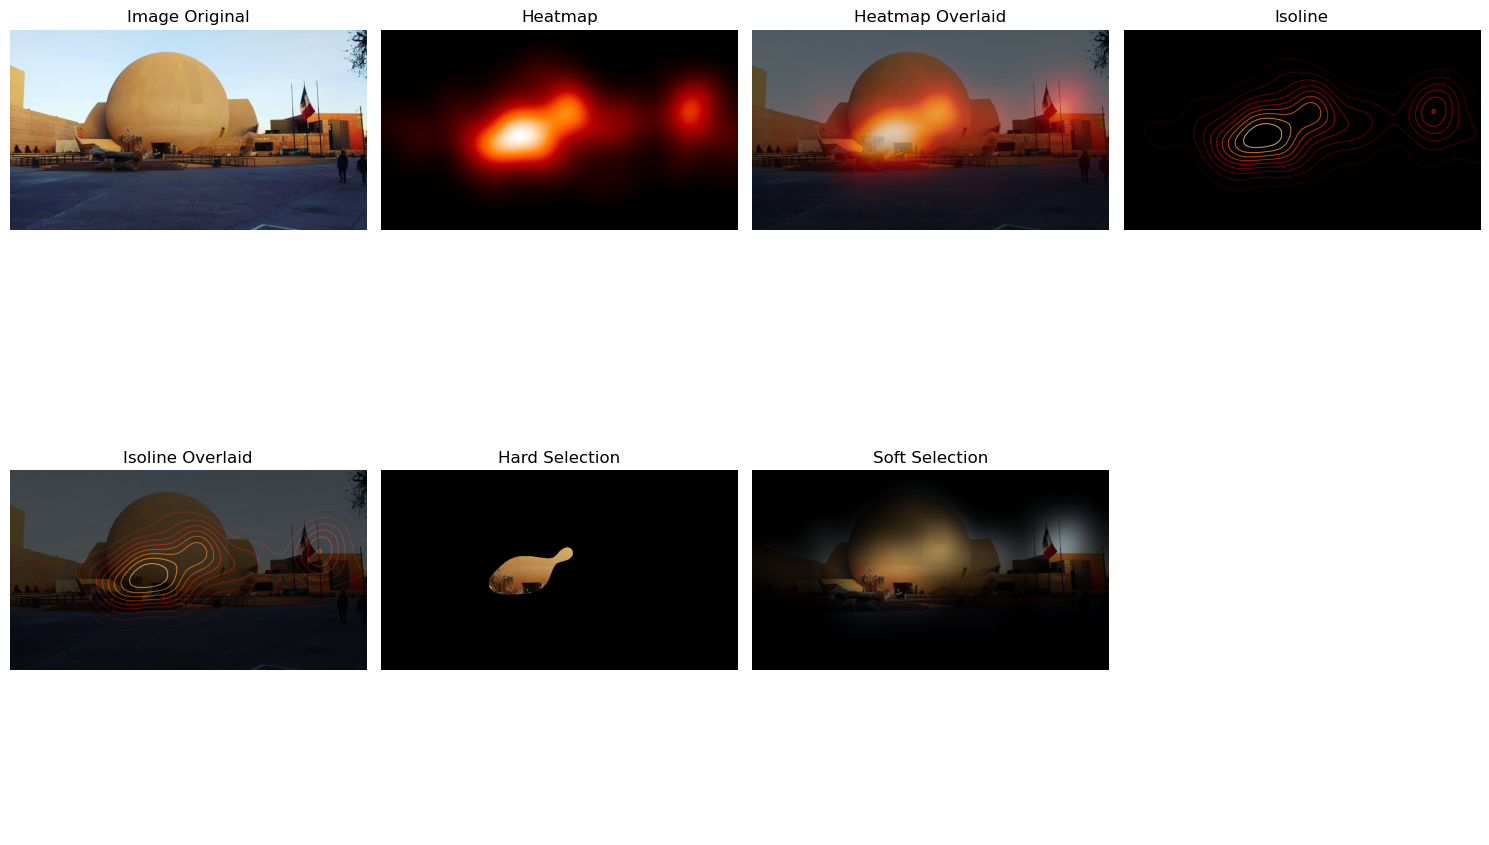

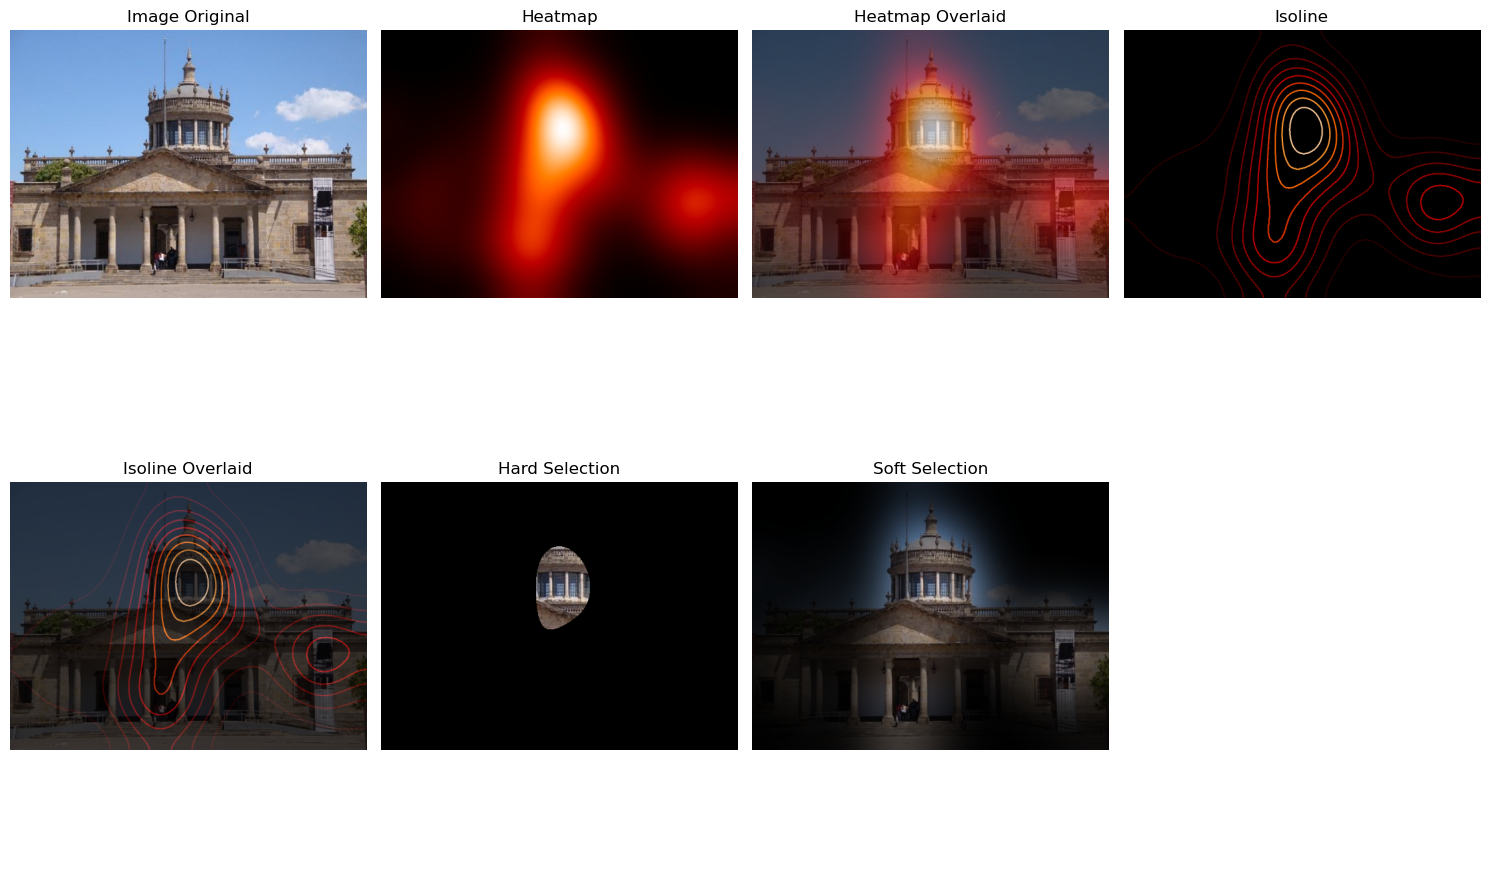

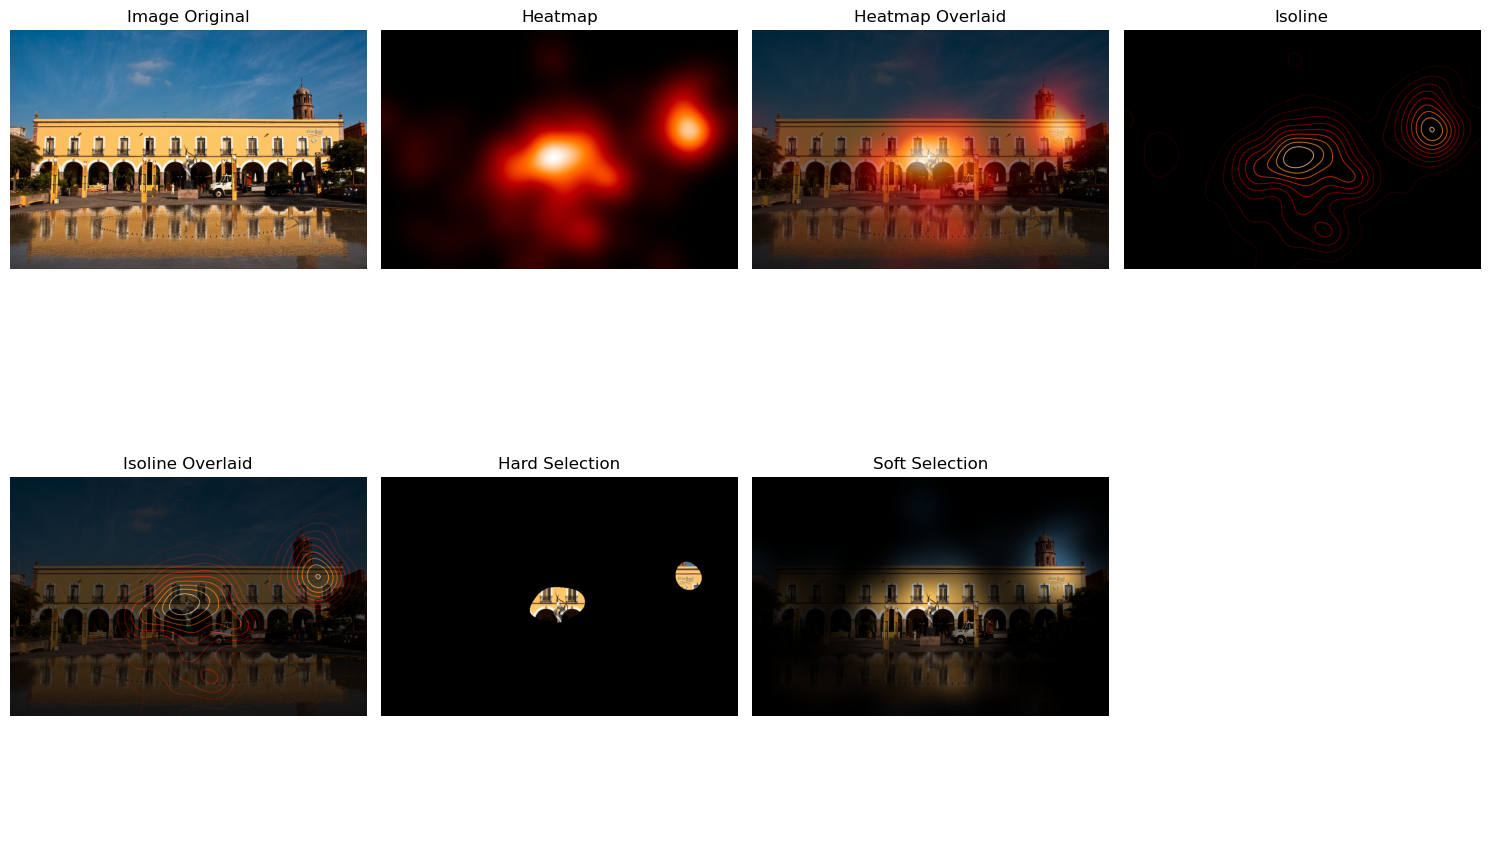

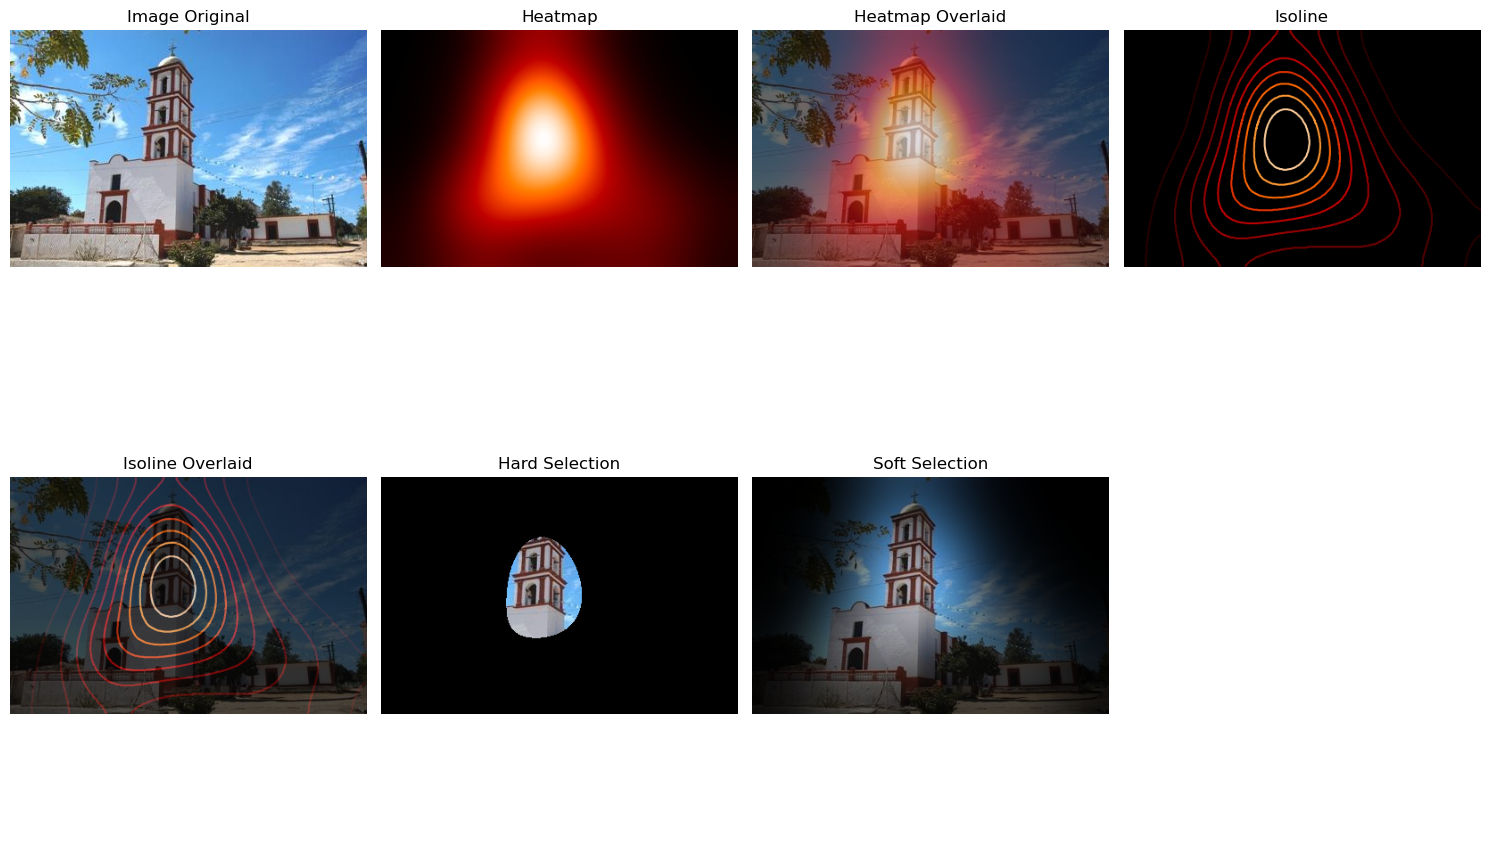

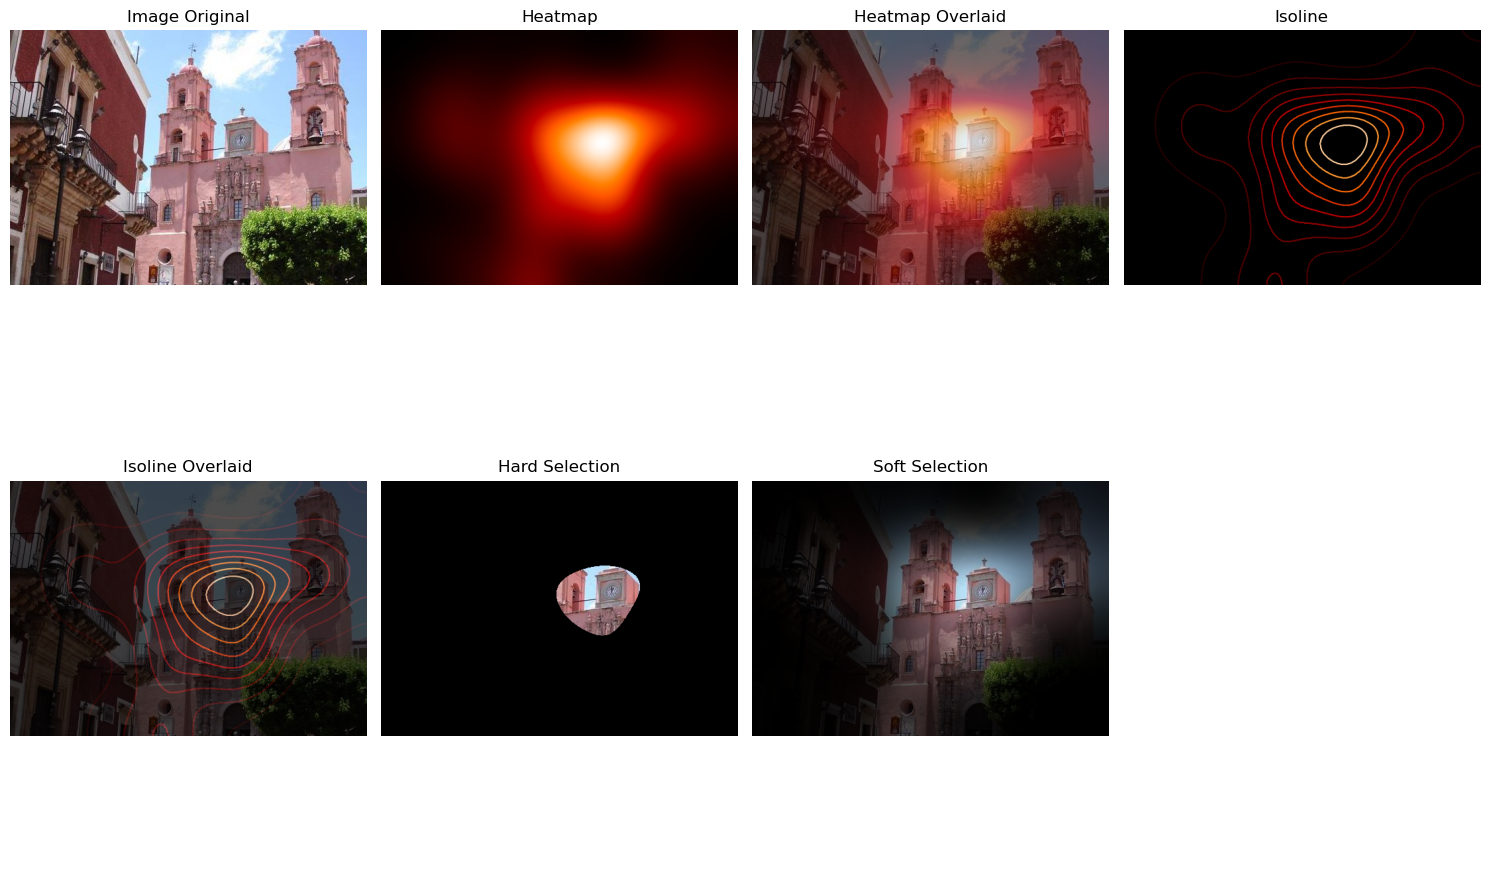

In [17]:
def LoadData(directoryImage, directorySaliency, ImageNumber):
    for filename in os.listdir(directoryImage):
        if ImageNumber>0:
            saliency_path =  os.path.join(directorySaliency,filename)
            images_path = os.path.join(directoryImage,filename)
            grid_comparison(images_path, saliency_path)
            
            ImageNumber-=1
        else:
            break

saliency_dir = './../MexCulture142/saliency'           
total_images_dir = './../MexCulture142/ImageTotal' 
X = LoadData(total_images_dir,saliency_dir, 5)

## Comparaison des approches

- Les heatmaps offrent une visualisation claire à comprendre. Les points importants sont facilement mis en avant, ce qui peut se faire au détriment de la vision de l'image.
- Les isolines permettent une analyse précise des variations. On voit bien les détails mais il n'est pas facile à l'interpréter.
- Les sélections (hard et soft) offrent un compromis de lisibilité et restent très simples à comprendre.

## Approche gagnante

Je n'ai pas l'impression qu'il existe une approche universellement meilleure. Suivant les objectifs, l'une peut se distinguer des autres :

- La heatmap superposée -> pour son intuitivité
- Les isolines superposées ou la soft selection -> pour l'analyse détaillée